# Data Preprocessing and Model Building

## Data Preprocessing

## Helper Functions

Function to convert date and time:

In [7]:
def convert_to_datetime(frame, column, fm="%Y-%m-%d"):    
    frame[column] = pd.to_datetime(frame[column],format=fm)
    frame[column + '_' + 'year'], frame[column + '_' + 'month'], frame[column + '_' + 'day'] = \
    frame[column].dt.year, frame[column].dt.month, frame[column].dt.day
    
    return frame

Class to impute missing values. If the variable is categorical, use mode; if the variable is numerical, use median.

In [5]:
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series(["missing" if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

Function for getting the sorted_index and sorted_list for a given list:

In [6]:
def pred_to_rank(data, search_id=None):
    my_search = data['srch_id' == search_id]
    sorted_index = [i[0] for i in sorted(enumerate(my_search), key=lambda x:x[1])]
    sorted_list = sorted(data)
    return sorted_index, sorted_list

## Model Building

In [19]:
from time import time

import pandas as pd
import numpy as np
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [4]:
file_path = "/home/mengling/myproject/hotels/imp_sample.txt"
data = pd.read_table(file_path, sep="\t")
data.describe(include=['O'])

,date_time,visitor_id,visitor_loc_country,visitor_loc_region,visitor_loc_city,visitor_wr_member,posa_continent,posa_country,srch_ci,srch_co,device,currency,click_datetime,booking_datetime,prop_super_region,prop_continent,prop_country,local_date
count,1205488,1205488,1205488,1205253,1205488,570690,506122,1205488,1205488,1205488,1205488,1016115,52362,34077,1205488,1205488,1205488,1205488
unique,33768,32333,162,630,6111,9,4,69,405,401,3,52,51347,33805,4,4,8,28
top,2014-09-18 21:18:20,0fac9b35-d7b7-4b71-b275-7da40310ea2e,UNITED STATES OF AMERICA,CA,NEW YORK,Not Signed In|Returning Visitor|Not FC Member,EUROPE,US,2014-09-26,2014-09-28,DESKTOP,USD,2014-09-04 21:40:00,2014-09-08 19:02:00,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,2014-09-03
freq,144,1214,667876,167829,29858,268283,297315,668191,33352,42112,1029876,596126,3,3,799139,799139,799139,55371


## Feature Engineering

Convert Datetime to Year, Month and Day:

In [8]:
data = convert_to_datetime(data, "srch_ci","%Y-%m-%d")
data = convert_to_datetime(data, "srch_co","%Y-%m-%d")
data = convert_to_datetime(data, "local_date","%Y-%m-%d")
data['date_time_hour'] = pd.to_datetime(data['date_time'],format="%Y-%m-%d %H:%M:%S").dt.hour
drop_columns = ['click_datetime','booking_datetime','srch_ci','srch_co', 'local_date','date_time']
data = data.drop(drop_columns, axis=1)

Create counts by city, country and counts by the combination of city, country and search:

In [9]:
gb_city = pd.DataFrame({'count_by_city' : data.groupby( ["visitor_loc_city"] , as_index=False).size()}).reset_index()
gb_city_srch = pd.DataFrame({'count_by_city_srch' : data.groupby( ["visitor_loc_city", "srch_id"] , \
                                                                 as_index=False).size()}).reset_index()
gb_visitor = pd.DataFrame({'count_by_visitor' : data.groupby( ["visitor_id"] , as_index=False).size()}).reset_index()

gb_reg = pd.DataFrame({'count_by_region' : data.groupby( ["visitor_loc_region"] , as_index=False).size()}).reset_index()
gb_reg_srch = pd.DataFrame({'count_by_reg_srch' : data.groupby( ["visitor_loc_region", "srch_id"] , \
                                                               as_index=False).size()}).reset_index()

gb_country = pd.DataFrame({'count_by_country' : data.groupby( ["visitor_loc_country"] , as_index=False).size()}).reset_index()
gb_country_srch = pd.DataFrame({'count_by_country_srch' : data.groupby( ["visitor_loc_country", "srch_id"] , \
                                                                       as_index=False).size()}).reset_index()

gb_posa_ctry = pd.DataFrame({'count_by_posa_ctry' : data.groupby( ["posa_country"] , as_index=False).size()}).reset_index()
gb_posa_ctry_srch = pd.DataFrame({'count_by_posa_ctry_srch' : data.groupby( ["posa_country", "srch_id"] , \
                                                                           as_index=False).size()}).reset_index()
gb_prop_country = pd.DataFrame({'count_by_prop_country' : data.groupby( ["prop_country"] , as_index=False).size()}).reset_index()
gb_prop_country_srch = pd.DataFrame({'count_by_prop_country_srch' : data.groupby( ["prop_country", "srch_id"] , \
                                                                 as_index=False).size()}).reset_index()

data = pd.merge(data, gb_city, on="visitor_loc_city", how="left")
data = pd.merge(data, gb_city_srch, on=["visitor_loc_city", "srch_id"], how="left")
data = pd.merge(data, gb_reg, on="visitor_loc_region", how="left")
data = pd.merge(data, gb_reg_srch, on=["visitor_loc_region", "srch_id"], how="left")
data = pd.merge(data, gb_country, on="visitor_loc_country", how="left")
data = pd.merge(data, gb_country_srch, on=["visitor_loc_country", "srch_id"], how="left")
data = pd.merge(data, gb_posa_ctry, on="posa_country", how="left")
data = pd.merge(data, gb_posa_ctry_srch, on=["posa_country", "srch_id"], how="left")
data = pd.merge(data, gb_prop_country, on="prop_country", how="left")
data = pd.merge(data, gb_prop_country_srch, on=["prop_country", "srch_id"], how="left")
data = pd.merge(data, gb_visitor, on="visitor_id", how="left")

Create the discount ratio:

In [10]:
data['discount_ratio'] = (data['price_without_discount_usd'] - 
                          data['price_with_discount_usd']) / data['price_without_discount_usd']

In [11]:
drop_columns = ['srch_id','visitor_id', 'visitor_loc_city', 'visitor_loc_region', \
                'visitor_loc_country', 'posa_country','currency', 'prop_country']
data = data.drop(drop_columns, axis=1)

In [47]:
data.describe(include=["O"])

,visitor_wr_member,posa_continent,device,prop_super_region,prop_continent
count,570690,506122,1205488,1205488,1205488
unique,9,4,3,4,4
top,Not Signed In|Returning Visitor|Not FC Member,EUROPE,DESKTOP,AMER,NORTHAMERICA
freq,268283,297315,1029876,799139,799139


Impute missing values:

In [12]:
imp = DataFrameImputer()
y = data.position
X = data.drop("position", axis=1)
X = imp.fit_transform(X)

Counts of missing values in each column:

In [128]:
#X.isnull().sum()
#X.info()


Vectorize the data:

In [13]:
X_dummy = pd.get_dummies(X)

In [50]:
X_dummy.columns

Index(['visitor_visit_nbr', 'srch_hcom_destination_id', 'srch_dest_longitude',
       'srch_dest_latitude', 'srch_ci_day', 'srch_co_day', 'srch_los',
       'srch_bw', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'mobile_bool', 'mobile_app', 'travelad_bool', 'dotd_bool',
       'price_without_discount_local', 'price_without_discount_usd',
       'price_with_discount_local', 'price_with_discount_usd', 'imp_drr',
       'click_bool', 'booking_bool', 'prop_key', 'prop_brand_bool',
       'prop_starrating', 'prop_market_id', 'prop_submarket_id',
       'prop_room_capacity', 'prop_review_score', 'prop_review_count',
       'prop_hostel_bool', 'srch_ci_year', 'srch_ci_month', 'srch_co_year',
       'srch_co_month', 'local_date_year', 'local_date_month',
       'local_date_day', 'date_time_hour', 'count_by_city',
       'count_by_city_srch', 'count_by_region', 'count_by_reg_srch',
       'count_by_country', 'count_by_country_srch', 'count_by_posa_ctry',
       'count_by_posa_

In [51]:
columns = ['visitor_wr_member_Not Signed In|Returning Visitor|Not FC Member', 'posa_continent_EUROPE',\
          'device_DESKTOP', 'prop_super_region_LATAM', 'prop_continent_EUROPE']
X_dummy = X_dummy.drop(columns, axis=1)

In [52]:
X_dummy.shape

(1205488, 72)

In [ ]:
#from sklearn.feature_extraction import DictVectorizer
#vec = DictVectorizer(sparse=True)
#XDict = X.to_dict(orient='records')
#XArray = vec.fit_transform(XDict).toarray()

Since the dataset is large, I can not run models on the whole data with all the parameters on my laptop, I would like to downsample the data, and run it with all the parameters and find the best parameters then increase the data size.

In [15]:
X_s = X_dummy.sample(10000)
y_s = y.ix[X_s.index]
X_holdout = X_dummy.drop(X_s.index)
y_holdout = y.drop(X_s.index)

### Split the data:

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_s, y_s, test_size=0.3)

### Benchmark: MAE for the position

The Absolute Mean Error in the training data (this is equivalent to no model):

In [69]:
print(y_s.mean())
np.mean(abs(y_s - y_s.mean()))

24.223


13.504314399999947

### Elastic-Net Model:

Set the parameters by cross-validation

In [72]:
tuned_parameters = {'l1_ratio': [0.5,0.8,1], 'alpha': [0.1, 0.01,0.001, 0.0001], \
                    'max_iter': [2000], "normalize":[True]}

In [73]:
en = ElasticNet()
clf = GridSearchCV(estimator=en, param_grid=tuned_parameters, cv=3, scoring='mean_absolute_error',verbose=0)
clf_fit = clf.fit(X_train, y_train)


/home/mengling/anaconda3/envs/hotels/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Evaluate the performance:

In [74]:
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:

{'alpha': 0.0001, 'max_iter': 2000, 'normalize': True, 'l1_ratio': 1}

Grid scores on development set:

-13.440 (+/-0.247) for {'alpha': 0.1, 'max_iter': 2000, 'normalize': True, 'l1_ratio': 0.5}
-13.450 (+/-0.248) for {'alpha': 0.1, 'max_iter': 2000, 'normalize': True, 'l1_ratio': 0.8}
-13.456 (+/-0.247) for {'alpha': 0.1, 'max_iter': 2000, 'normalize': True, 'l1_ratio': 1}
-13.086 (+/-0.231) for {'alpha': 0.01, 'max_iter': 2000, 'normalize': True, 'l1_ratio': 0.5}
-12.774 (+/-0.219) for {'alpha': 0.01, 'max_iter': 2000, 'normalize': True, 'l1_ratio': 0.8}
-11.571 (+/-0.156) for {'alpha': 0.01, 'max_iter': 2000, 'normalize': True, 'l1_ratio': 1}
-11.931 (+/-0.170) for {'alpha': 0.001, 'max_iter': 2000, 'normalize': True, 'l1_ratio': 0.5}
-11.609 (+/-0.135) for {'alpha': 0.001, 'max_iter': 2000, 'normalize': True, 'l1_ratio': 0.8}
-11.378 (+/-0.118) for {'alpha': 0.001, 'max_iter': 2000, 'normalize': True, 'l1_ratio': 1}
-11.423 (+/-0.122)

On the test data:

In [75]:
y_true, y_pred = y_test, clf.predict(X_test)
print(mean_absolute_error(y_true, y_pred))


11.6330616957


Retrain the best model with all the data and get the feature Coefficients:

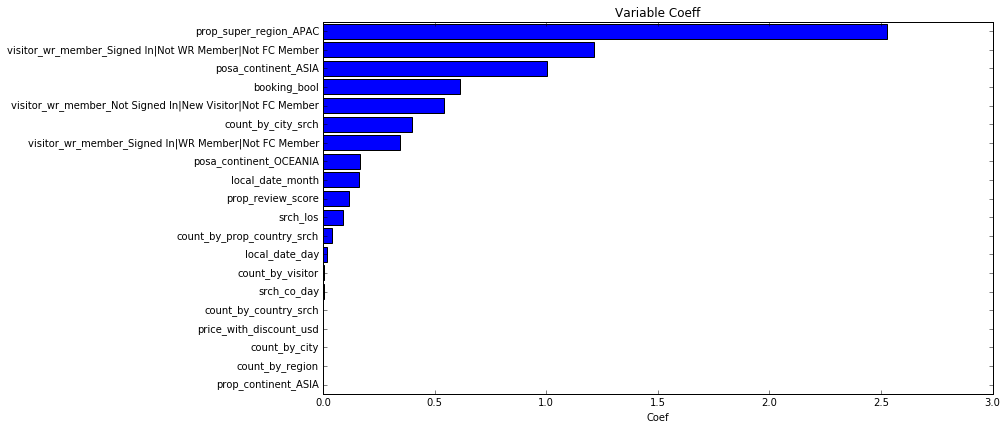

In [76]:
%matplotlib inline
en = ElasticNet(l1_ratio=1, alpha=0.0005, normalize=True, max_iter=4000)
clf = en.fit(X_s, y_s)
import matplotlib.pyplot as plt
feature_names = list(X_s.columns)
ndisplay = 20
feature_tup = zip(feature_names, en.coef_)
feature_tup1 = sorted(feature_tup, key=lambda x: x[1])
feature_tup = feature_tup1[-ndisplay:]
names, importance = zip(*feature_tup)

pos = np.arange(len(names)) + .5
plt.figure(figsize=(12, ndisplay/3.))
plt.barh(pos, importance, align='center')
plt.yticks(pos, names)
plt.xlabel('Coef')
plt.title('Variable Coeff')

### Gradient Boosting Machine:

In [77]:
tuned_parameters = {'loss':['lad'], 'learning_rate':[0.005,0.001], \
                    'n_estimators':[300], 'subsample':[1.0], 'max_depth':[3,5,7],'min_samples_split':[10,20]}


In [89]:
gbr = GradientBoostingRegressor()
clf = GridSearchCV(estimator=gbr, param_grid=tuned_parameters, cv=3, scoring='mean_absolute_error',verbose=0)
clf_fit = clf.fit(X_train, y_train)

In [90]:
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:

{'max_depth': 7, 'learning_rate': 0.005, 'min_samples_split': 10, 'subsample': 1.0, 'n_estimators': 300, 'loss': 'lad'}

Grid scores on development set:

-11.555 (+/-0.238) for {'max_depth': 3, 'learning_rate': 0.005, 'min_samples_split': 10, 'subsample': 1.0, 'n_estimators': 300, 'loss': 'lad'}
-11.550 (+/-0.245) for {'max_depth': 3, 'learning_rate': 0.005, 'min_samples_split': 20, 'subsample': 1.0, 'n_estimators': 300, 'loss': 'lad'}
-11.126 (+/-0.237) for {'max_depth': 5, 'learning_rate': 0.005, 'min_samples_split': 10, 'subsample': 1.0, 'n_estimators': 300, 'loss': 'lad'}
-11.112 (+/-0.246) for {'max_depth': 5, 'learning_rate': 0.005, 'min_samples_split': 20, 'subsample': 1.0, 'n_estimators': 300, 'loss': 'lad'}
-10.756 (+/-0.237) for {'max_depth': 7, 'learning_rate': 0.005, 'min_samples_split': 10, 'subsample': 1.0, 'n_estimators': 300, 'loss': 'lad'}
-10.758 (+/-0.259) for {'max_depth': 7, 'learning_rate': 0.005, 'min_samples_split':

In [31]:
y_true, y_pred = y_test, clf.predict(X_test)
print(mean_absolute_error(y_true, y_pred))

11.0666027811


Retrain the model with all the data and vary n_estimators.

8.87507440524


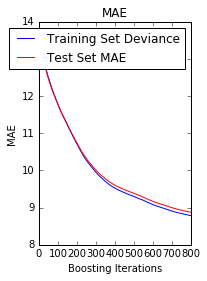

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
params = {'max_depth': 7, 'learning_rate': 0.005, 'min_samples_split': 10, \
          'subsample': 1.0, 'n_estimators': 800, 'loss': 'lad'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_s, y_s)
mae = mean_absolute_error(y_test, clf.predict(X_test))

print(mae)

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.subplot(1, 2, 1)
plt.title('MAE')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set MAE')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('MAE')



 Plot the variable importance:

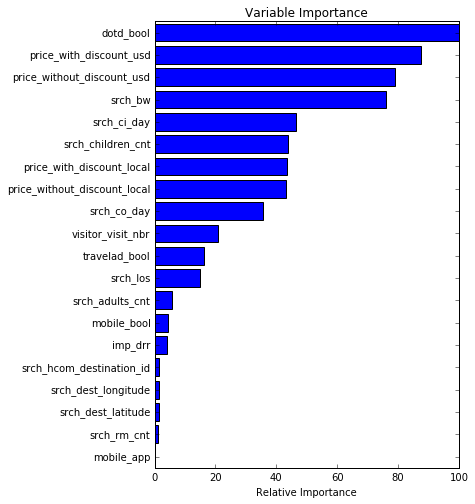

In [35]:
# Plot feature importance
feature_importance = clf.feature_importances_[:20]
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=[12,8]) 
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()